# GCNN Point estimation

This code gives you point estimation of cosmological parameters($\sigma_8$ vs. $\Omega_m$) from flask log-normal convergence maps (Xavier et al. 2016, MNRAS Vol. 459, p. 3693 (arXiv:1602.08503)) using DeepSphere GCNN layers(Perraudin et al. 2019, Astronomy and Computing Vol. 27, p. 130-146(arXiv:1810.12186)).
In this architecture, convergence maps with cosmological parameters($\sigma_8$ and $\Omega_m$) as labels are the inputs and outputs are cosmological parameters. So this is typical regression task. 

## 1.Importing the required packages and checking how many GPU are available

In [1]:
import os
import healpy as hp
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 2. Loading the Flask maps from flask_sim.py
Here we load the flask maps with different cosmologies. 800 flask maps are for training data sets, 200 for validation data sets, and 200 for test data sets which is generated from the cosmologies which is picked up with latin hypercube sampling from same prior cosmology but different random seed.

In [3]:
training_data =np.load('/project/ls-gruen/users/r.kanaki/DeepSphere_data/Versuch1/training_data_NSIDE128_NEST.npz')
testing_data=np.load('/project/ls-gruen/users/r.kanaki/DeepSphere_data/Versuch1/test_data_NSIDE128_NEST.npz')

In [4]:
train_data=training_data['lognormal_map']
test_data =testing_data['lognormal_map']
train_label_Omega_M=training_data['Omega_M']
train_label_sigma_8=training_data['sigma_8']
test_label_Omega_M=testing_data['Omega_M']
test_label_sigma_8=testing_data['sigma_8']

## 2.1 Visualizing the one of the flask maps(for your eyes?)

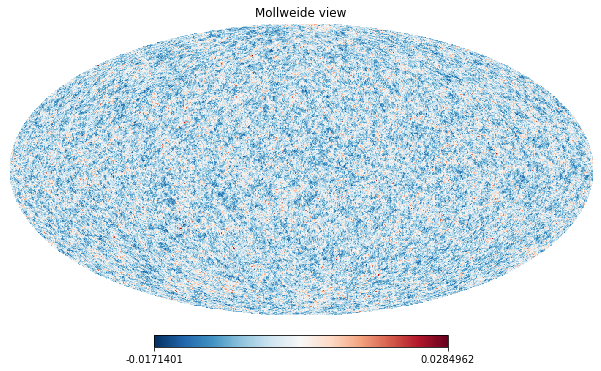

In [5]:
cmin = np.min(train_data[1])
cmax = np.max(train_data[1])
cm = plt.cm.RdBu_r
hp.mollview(train_data[1], cmap=cm,nest=True, min=cmin, max=cmax)

## 2.2 Normalization of labels
Actually, it is not big issue, since the $\sigma_8$ and $\Omega_m$ have similar values, but still it affect final result emprically. 
I tested without normalization and mean,std normalization, best method is using maximum and minimum and normalize the distribution from 0 to 1.
Another important thing is "Do NOT use the information from test data sets" from the advice of Francois Chollet's book. But here it is trivial, since both maximum and minium are same for training and test datasets.

In [6]:
train_max_Omega_M=np.amax(train_label_Omega_M)
train_max_sigma_8=np.amax(train_label_sigma_8)
train_min_Omega_M=np.amin(train_label_Omega_M)
train_min_sigma_8=np.amin(train_label_sigma_8)
train_label_Omega_M=(train_label_Omega_M-train_min_Omega_M)/(train_max_Omega_M-train_min_Omega_M)
train_label_sigma_8=(train_label_sigma_8-train_min_sigma_8)/(train_max_sigma_8-train_min_sigma_8)
test_label_Omega_M=(test_label_Omega_M-train_min_Omega_M)/(train_max_Omega_M-train_min_Omega_M)
test_label_sigma_8=(test_label_sigma_8-train_min_sigma_8)/(train_max_sigma_8-train_min_sigma_8)

In [7]:
train_labels=np.zeros((1000,2))
test_labels=np.zeros((200,2))
for i in range(len(train_label_Omega_M)):
    train_labels[i]=np.array((train_label_Omega_M[i], train_label_sigma_8[i]))
for i in range(len(test_label_Omega_M)):
    test_labels[i]=np.array((test_label_Omega_M[i], test_label_sigma_8[i]))

Giving the resolution of flask maps

In [8]:
nside=128
npix = hp.nside2npix(nside)
indices = np.arange(npix)

In [9]:
x_train = train_data.astype(np.float32)[..., None]
x_test = test_data.astype(np.float32)[...,None]
np.random.RandomState(11).shuffle(x_train)
np.random.RandomState(11).shuffle(x_test)
labels_train=train_labels.astype(np.float32)
labels_test=test_labels.astype(np.float32)
np.random.RandomState(11).shuffle(labels_train)
np.random.RandomState(11).shuffle(labels_test)

## 3. Defining the architecture for the regression problem
DES surveys cover large part of sky, therefore rotational invariance plays important roles. However usual convolutional neural networks are translationally invariant but not rotationally. Therefore we use the graph convolutional neural networks layers from DeepSphere which is optimized for the HealPix maps.
Healpy.GCNN is the subclass of tf.keras.Sequential, therefore we can define as usual with keras and tensorflow.

In [10]:
num_epochs = 40
def build_model(hp):
    layers = [hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #0
                                   activation="relu"),
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #1
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),                                          #2
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #3
                                   activation="relu"),
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #4
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),                                          #5
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #6
                                   activation="relu"),
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #7
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),                                          #8
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #1
                                   activation="relu"),
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #12
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),                                          #13
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #14
                                   activation="relu"),
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #15
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),                                          #16
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #17
                                   activation="relu"),
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #18
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),                                          #19
          hp_layer.HealpyChebyshev(K=5, Fout=5,use_bias=False, use_bn=True,  #20
                                   activation="relu"),
          hp_layer.HealpyChebyshev(K=5, Fout=5, use_bias=False, use_bn=True, #21
                                   activation="relu"),
          tf.keras.layers.Flatten(),                                         #22
          tf.keras.layers.Dense(64, activation="sigmoid",use_bias=False),    #23
          #tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(2,use_bias=False)]                           #24
    tf.keras.backend.clear_session()
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    batch_size = 16
    model.build(input_shape=(None, len(indices), 1))
    learning_rate = hp.Float("lr", min_value=0.0005, max_value=0.001, sampling="log")
    #beta_1 = hp.Float("beta_1", min_value=0.6, max_value=1.0, sampling="log")
    #beta_2 = hp.Float("beta_2", min_value=0.99, max_value=1.0, sampling="log")
    #decay = learning_rate / num_epochs
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)#, beta_1=beta_1, beta_2=beta_2, decay=decay)
    model.compile(optimizer=opt,
              loss="mean_squared_error",
              metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

## 4. Optimizing the hyperparameters using keras.tuner
I am currently optimizing the hyperparameters using keras.tuner. I would learn soon TensorBoard and optimize the archtecture the way which is used in N. Smith, 2018(arXiv: 1803.09820v2)

In [11]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="Trial_Data",
    project_name="Test1")
tuner.search_space_summary()

Detected a reduction factor of 64.0, the input with nside 128 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Search space summary
Default search space size: 1
lr (Float)
{'default': 0.0005, 'conditions': [], 'min_value': 0.0005, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
tuner.search(x_train, labels_train, epochs=num_epochs, batch_size=16, callbacks=[callback],
    validation_split=0.2)

Trial 5 Complete [00h 07m 23s]
val_loss: 0.0019854248967021704

Best val_loss So Far: 0.0012594478903338313
Total elapsed time: 00h 37m 02s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in Trial_Data/Test1
Showing 10 best trials
Trial summary
Hyperparameters:
lr: 0.0005070819329341138
Score: 0.0012594478903338313
Trial summary
Hyperparameters:
lr: 0.0005782814274546449
Score: 0.001357254688628018
Trial summary
Hyperparameters:
lr: 0.0008687732402908409
Score: 0.0013775659026578069
Trial summary
Hyperparameters:
lr: 0.0006890123503055079
Score: 0.0019854248967021704
Trial summary
Hyperparameters:
lr: 0.0005089440520202987
Score: 0.0021745336707681417


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
prediction=best_model.predict(test_data)

Detected a reduction factor of 64.0, the input with nside 128 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...


## 5.Picking up the best model and hyperparameter of this

In [15]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('lr')}.""")

The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.0005070819329341138.


In [16]:
tf.keras.backend.clear_session()
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x_train,
    labels_train,
    batch_size=16,
    epochs=40,
    validation_split=0.2)

Detected a reduction factor of 64.0, the input with nside 128 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Epoch 1/40
50/50 [==============================] - 10s 137ms/step - loss: 0.3136 - mean_squared_error: 0.3136 - val_loss: 0.3965 - val_mean_squared_error: 0.3965
Epoch 2/40
50/50 [==============================] - 6s 123ms/step - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0750 - val_mean_squared_error: 0.0750
Epoch 3/40
50/50 [==============================] - 6s 123ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 4/40
50/50 [==============================] - 6s 123ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 5/40
50/50 [==============================] - 6s 123ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 6/40


## 6.Results and Plots

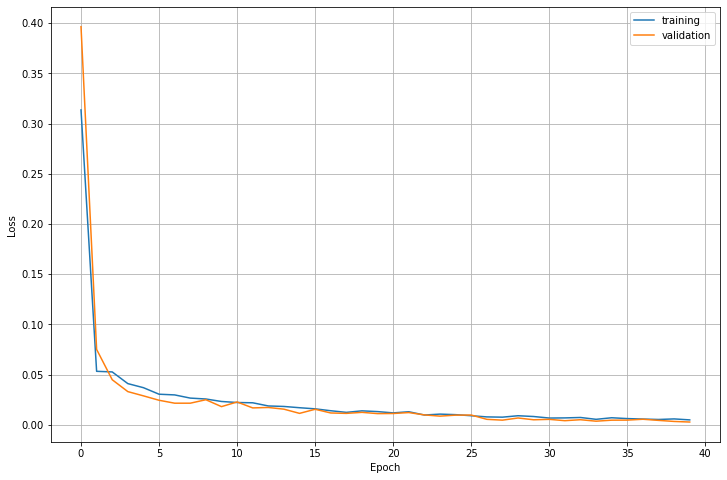

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('Plot/Loss_Curve.jpg',bbox_inches='tight')

### 6.1 Rescaling the cosmological parameters

In [18]:
estimated_Omega_M=prediction[:,0]*(train_max_Omega_M-train_min_Omega_M)+train_min_Omega_M#*train_std_Omega_M)+train_mean_Omega_M#
estimated_sigma_8=prediction[:,1]*(train_max_sigma_8-train_min_sigma_8)+train_min_sigma_8#*train_std_sigma_8)+train_mean_sigma_8#
true_Omega_M=test_labels[:,0]*(train_max_Omega_M-train_min_Omega_M)+train_min_Omega_M#*train_std_Omega_M)+train_mean_Omega_M#
true_sigma_8=test_labels[:,1]*(train_max_sigma_8-train_min_sigma_8)+train_min_sigma_8#*train_std_sigma_8)+train_mean_sigma_8#

In [19]:
train_min_Omega_M=np.amin(estimated_Omega_M)
train_min_sigma_8=np.amin(estimated_sigma_8)
train_max_Omega_M=np.amax(estimated_Omega_M)
train_max_sigma_8=np.amax(estimated_sigma_8)

Omega_M_x=np.linspace(train_min_Omega_M,train_max_Omega_M,100)
Omega_M_y=Omega_M_x
sigma_8_x=np.linspace(train_max_sigma_8,train_min_sigma_8,100)
sigma_8_y=sigma_8_x

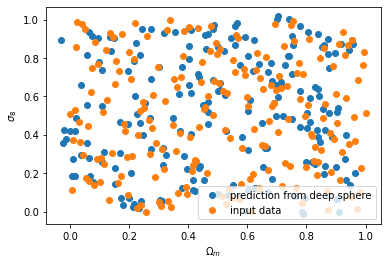

In [20]:
plt.scatter(prediction[:,0],prediction[:,1],label="prediction from deep sphere")
plt.scatter(test_labels[:,0],test_labels[:,1],label="input data")
plt.legend()
plt.xlabel(f"$\Omega_m$")
plt.ylabel(f"$\sigma_8$")
plt.savefig('Plot/scatter.jpg',bbox_inches='tight')

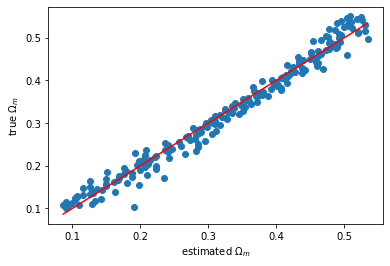

In [21]:
plt.scatter(estimated_Omega_M,true_Omega_M)
plt.plot(Omega_M_x,Omega_M_y,color='r')
plt.xlabel(f"estimated $\Omega_m$")
plt.ylabel(f"true $\Omega_m$")
plt.savefig('Plot/Omega_m.jpg',bbox_inches='tight')

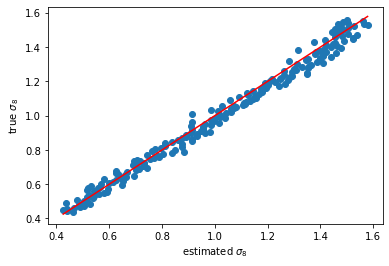

In [22]:
plt.scatter(estimated_sigma_8,true_sigma_8)
plt.plot(sigma_8_x,sigma_8_y,color="r")
plt.xlabel(f"estimated $\sigma_8$")
plt.ylabel(f"true $\sigma_8$")
plt.savefig('Plot/sigma_8.jpg',bbox_inches='tight')

## 7.Evaluating the difference from true values

In [23]:
frac_Omega_M=np.abs((estimated_Omega_M-true_Omega_M)/true_Omega_M)
frac_sigma_8=np.abs((estimated_sigma_8-true_sigma_8)/true_sigma_8)
diff_Omega_M=true_Omega_M-estimated_Omega_M
diff_sigma_8=true_sigma_8-estimated_sigma_8

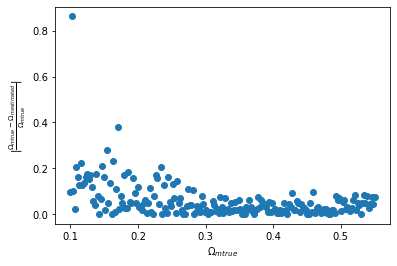

In [24]:
plt.scatter(true_Omega_M,frac_Omega_M)
plt.xlabel(r"${\Omega_m}_{true}$")
plt.ylabel(r"$|\frac{{\Omega_m}_{true}-{\Omega_m}_{estimated}}{{\Omega_m}_{true}}|$")
plt.savefig('Plot/Omega_m_diff.jpg',bbox_inches='tight')

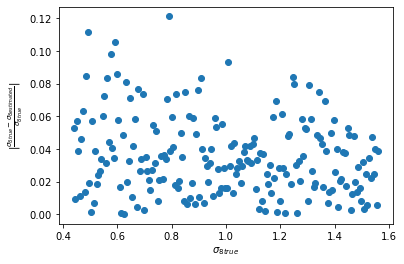

In [25]:
plt.scatter(true_sigma_8,frac_sigma_8)
plt.xlabel(r"${\sigma_8}_{true}$")
plt.ylabel(r"$|\frac{{\sigma_8}_{true}-{\sigma_8}_{estimated}}{{\sigma_8}_{true}}|$")
plt.savefig('Plot/sigma_8_diff.jpg',bbox_inches='tight')

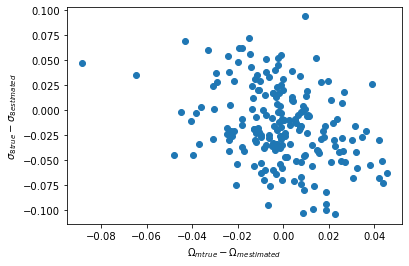

In [26]:
plt.scatter(diff_Omega_M,diff_sigma_8)
plt.xlabel(r"${\Omega_m}_{true}-{\Omega_m}_{estimated}$")
plt.ylabel(r"${\sigma_8}_{true}-{\sigma_8}_{estimated}$")
plt.savefig('Plot/diff.jpg',bbox_inches='tight')

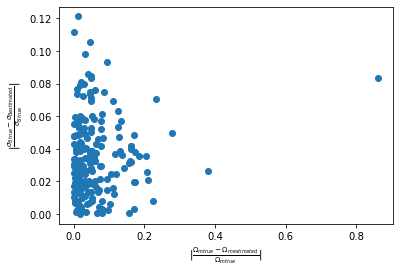

In [27]:
plt.scatter(frac_Omega_M,frac_sigma_8)
plt.xlabel(r"$|\frac{{\Omega_m}_{true}-{\Omega_m}_{estimated}}{{\Omega_m}_{true}}|$")
plt.ylabel(r"$|\frac{{\sigma_8}_{true}-{\sigma_8}_{estimated}}{{\sigma_8}_{true}}|$")
plt.savefig('Plot/fractional_diff.jpg',bbox_inches='tight')

## 8.Filter visualization

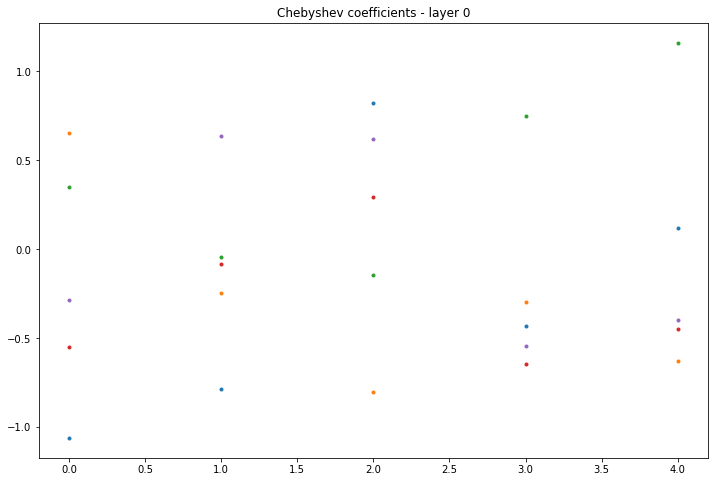

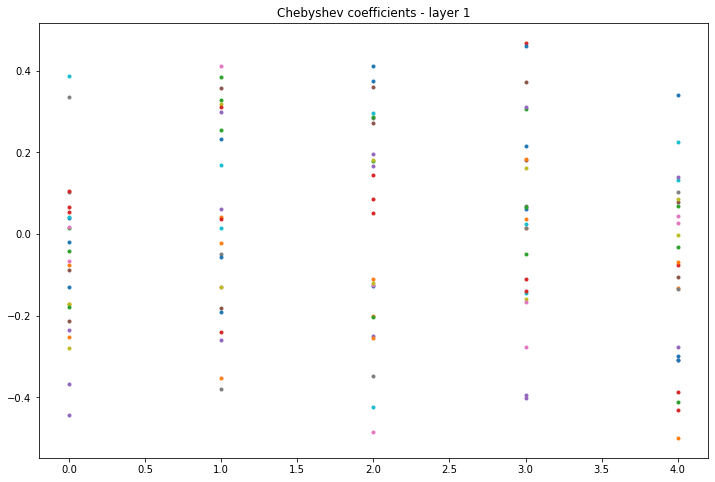

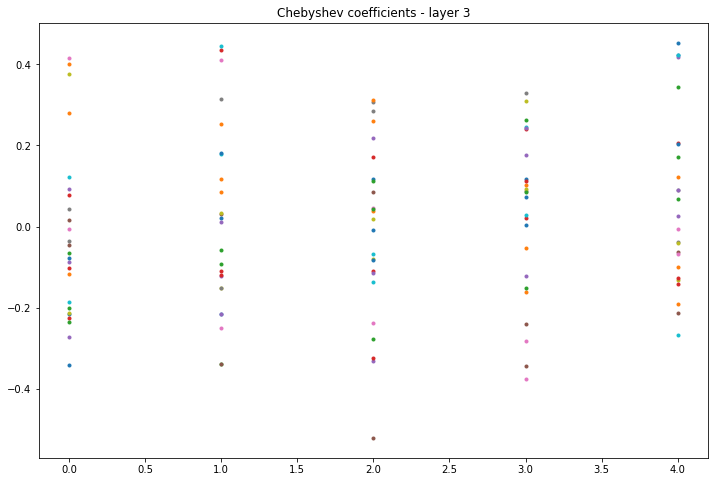

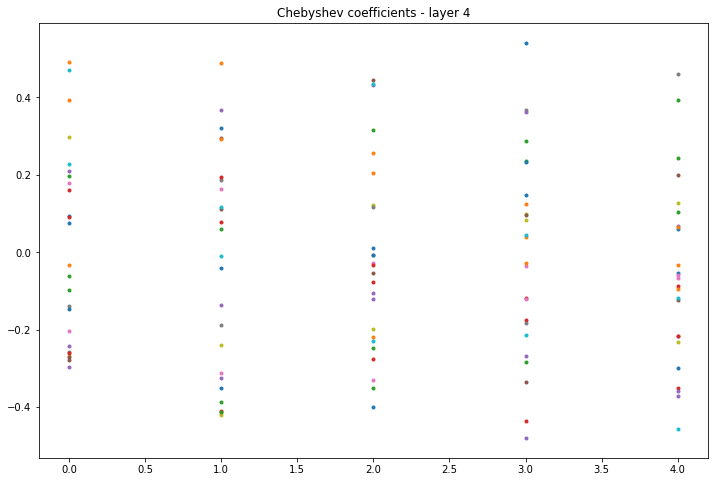

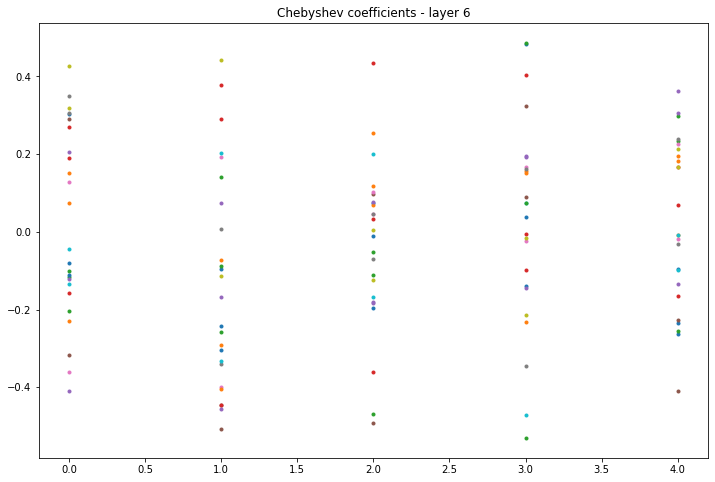

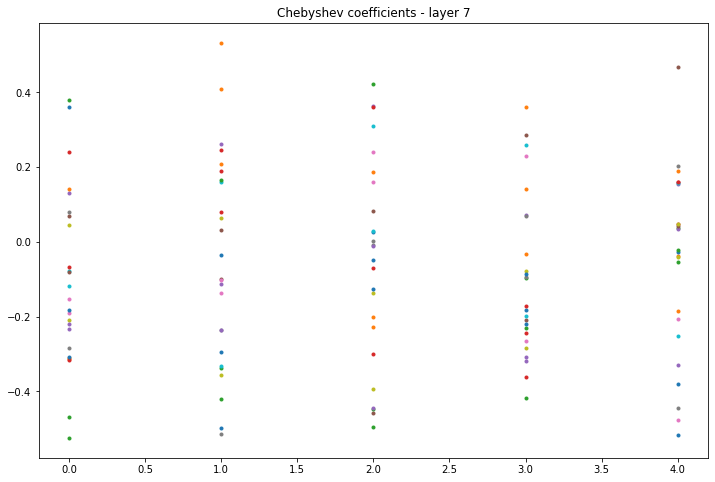

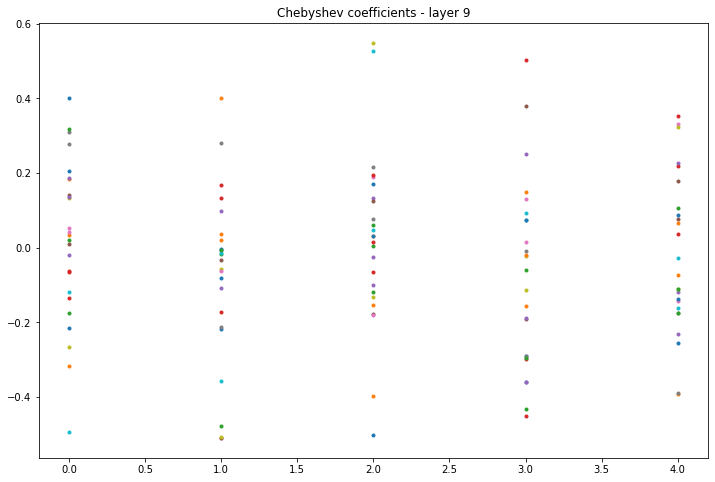

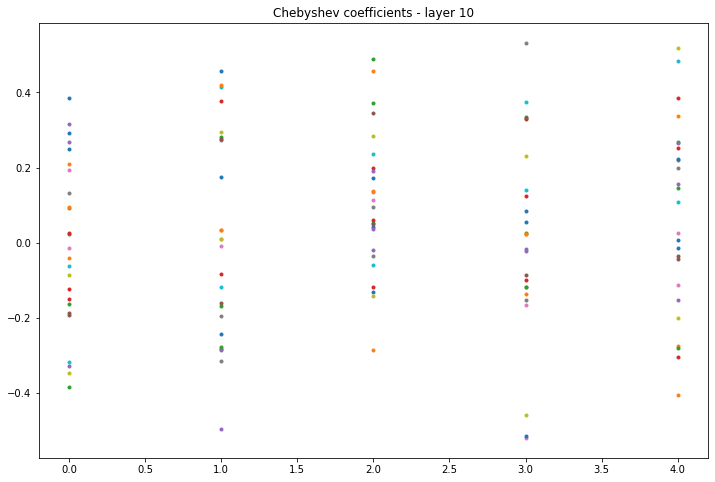

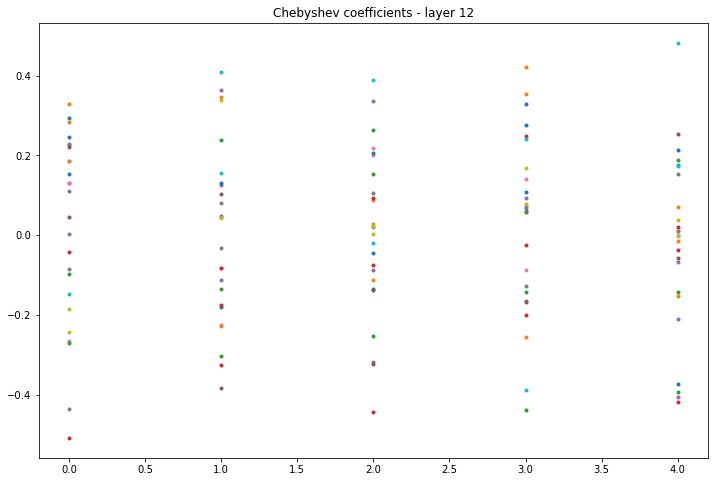

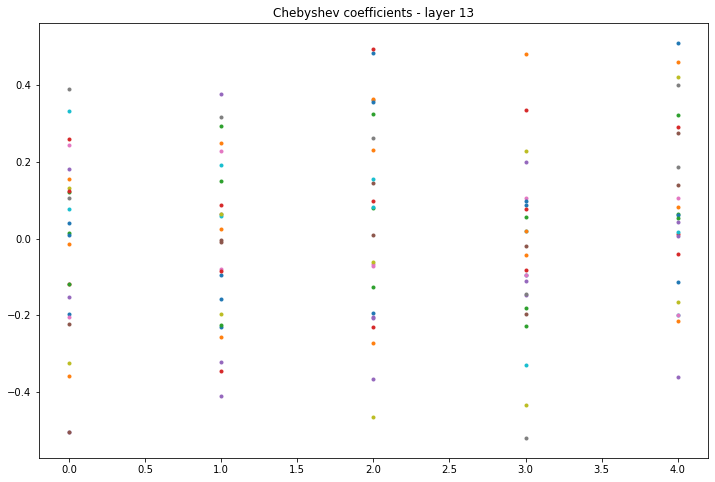

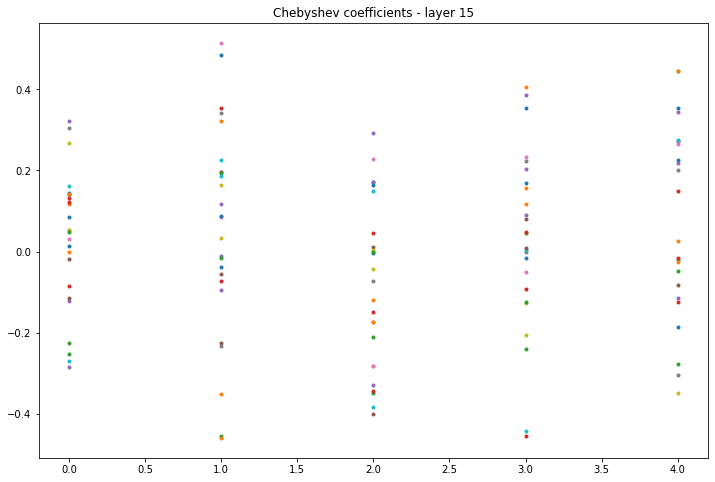

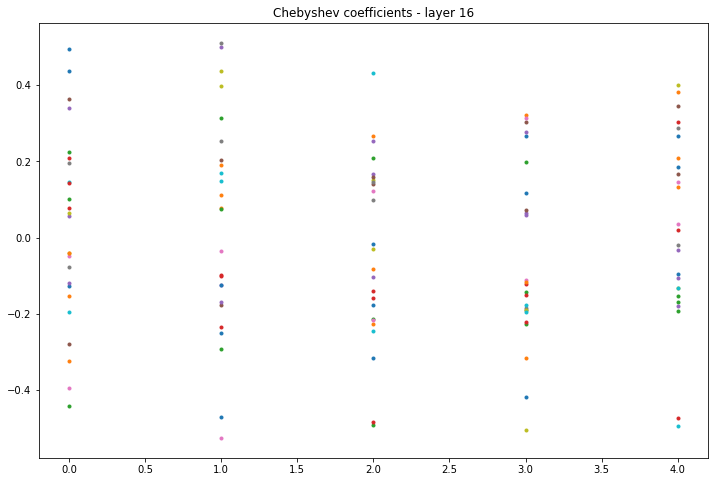

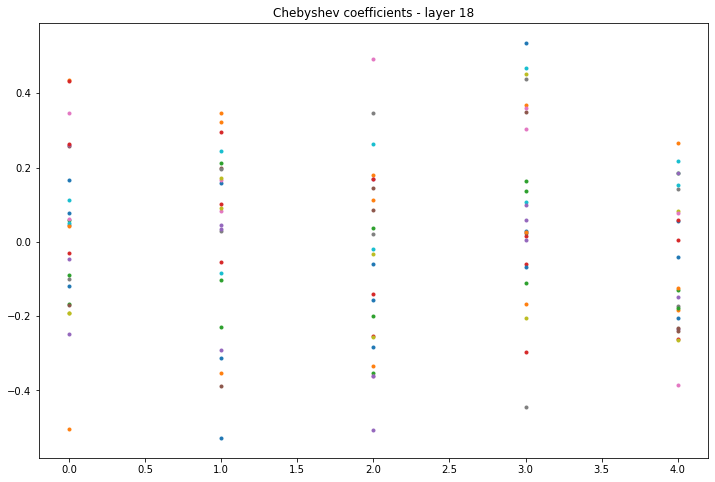

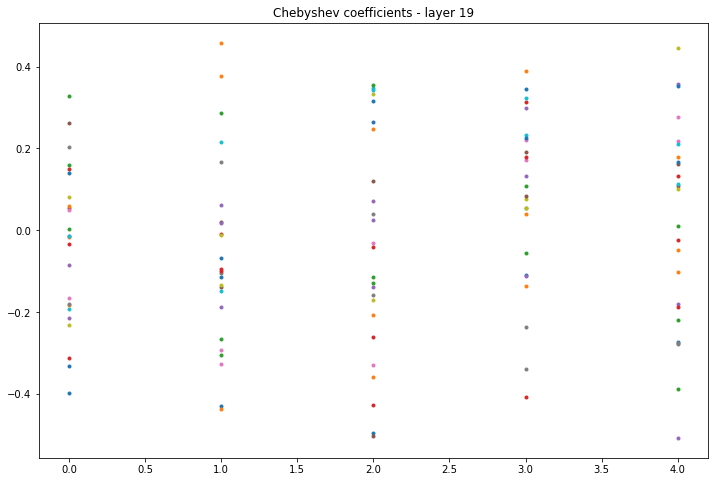

In [28]:
layer=[0,1,3,4,6,7,9,10,12,13,15,16,18,19]
for i in layer:
    plt.figure(figsize=(12,8))
    model.plot_chebyshev_coeffs(i)
    plt.savefig('Plot/filters/layer_'+str(i)+'_plot_chebyshev_coeffs.jpg',bbox_inches='tight')

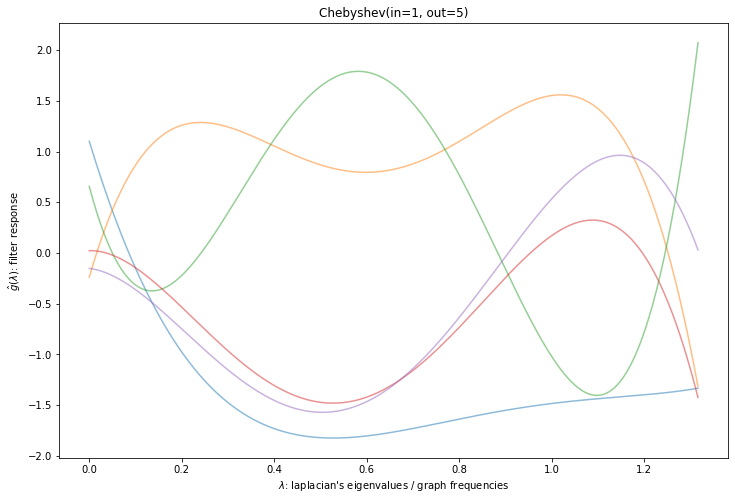

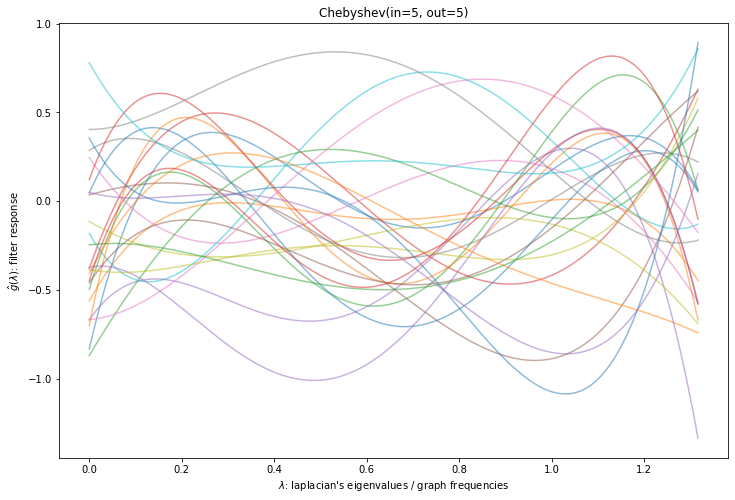

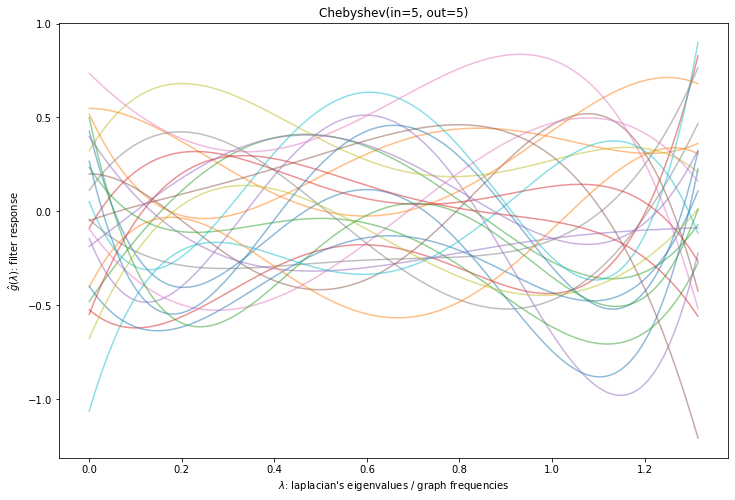

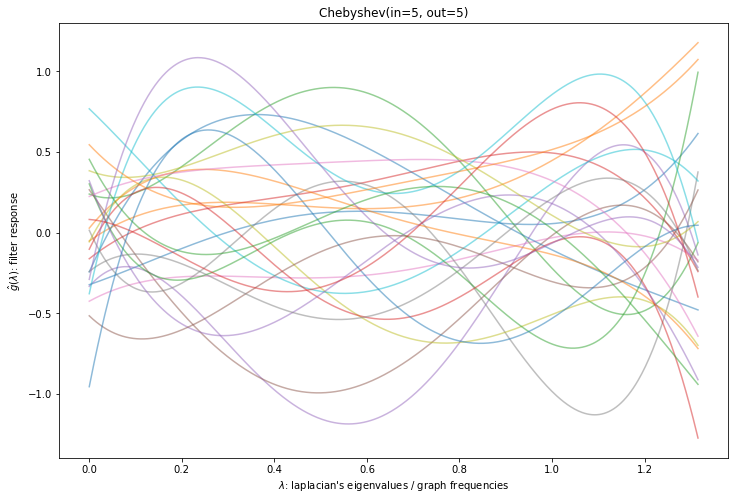

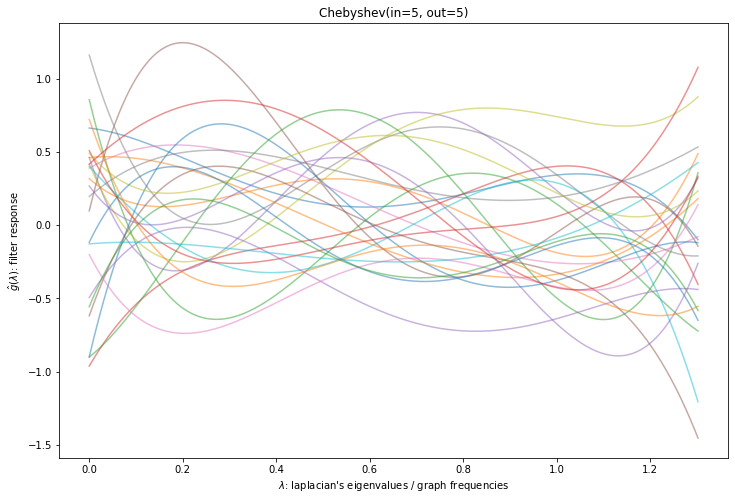

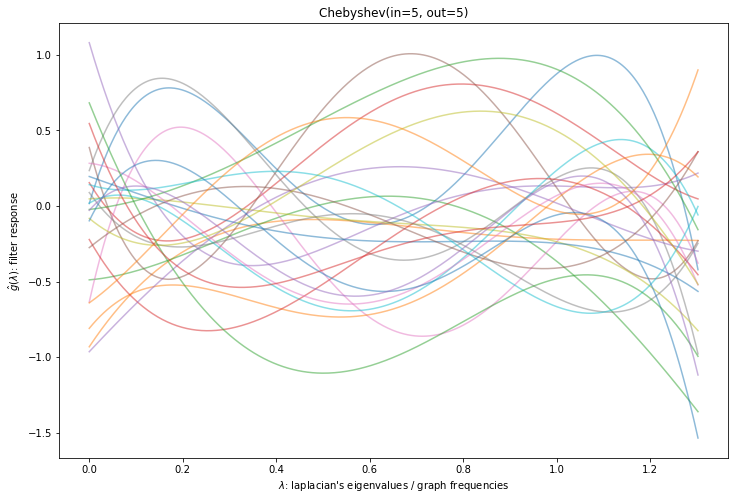

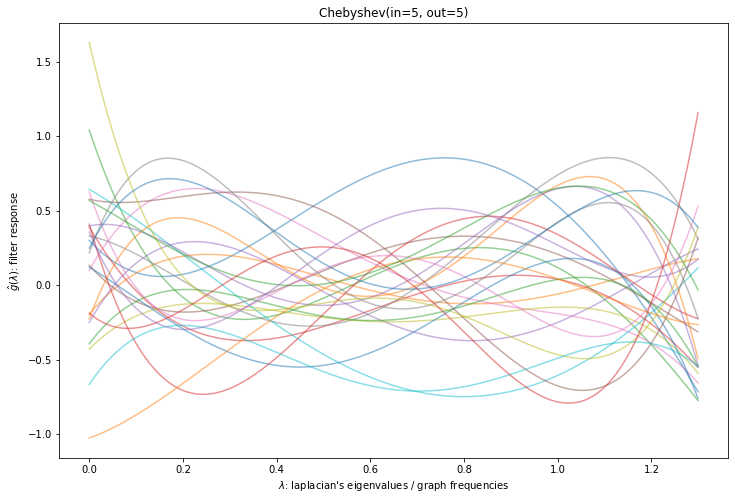

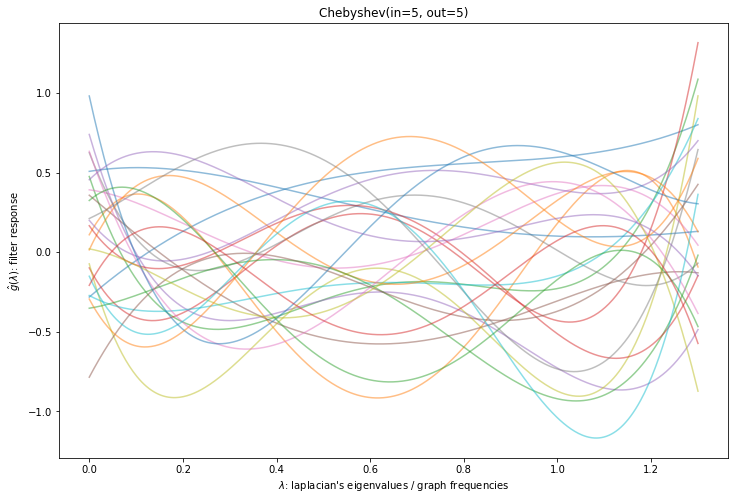

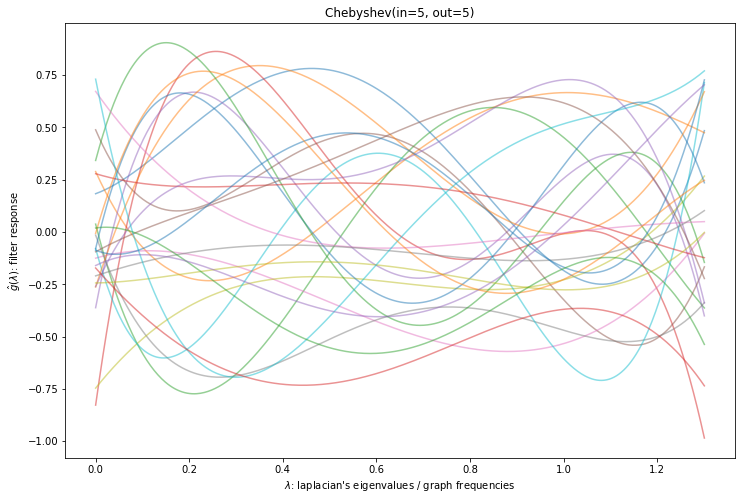

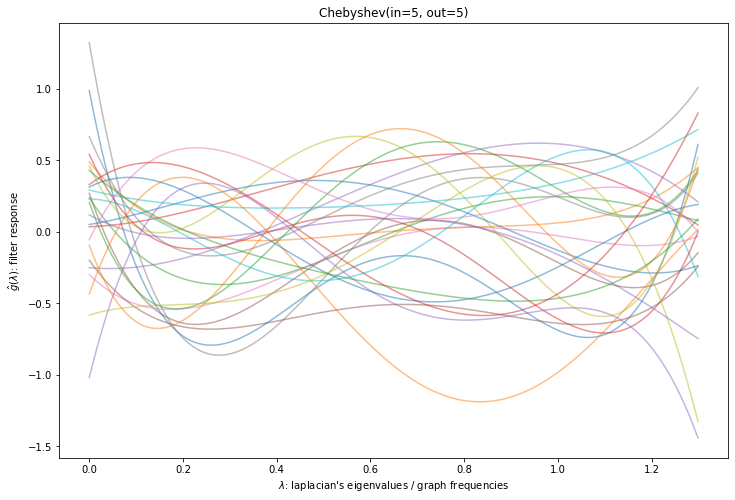

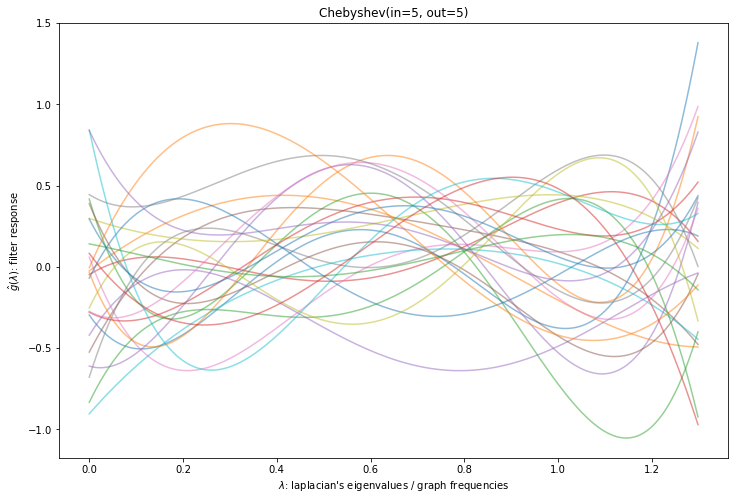

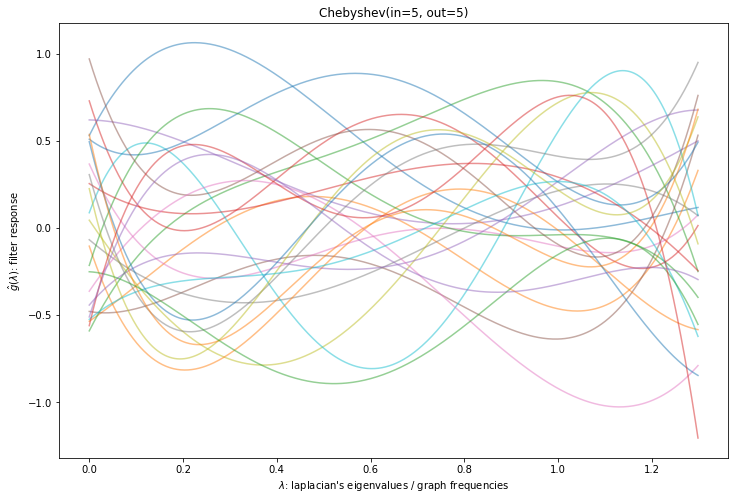

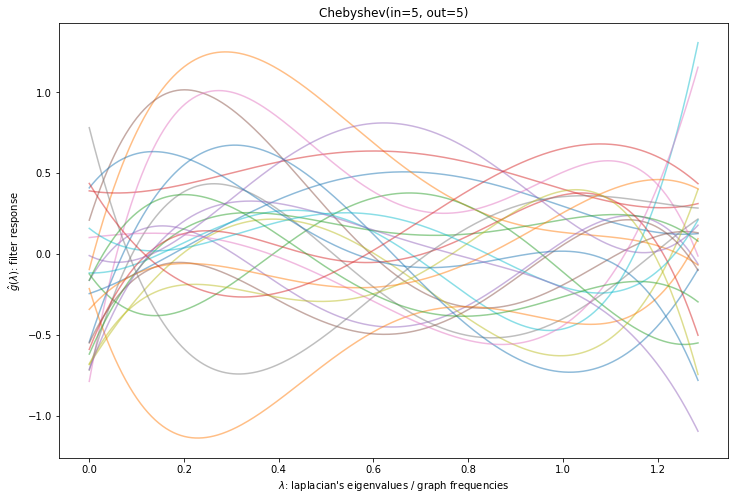

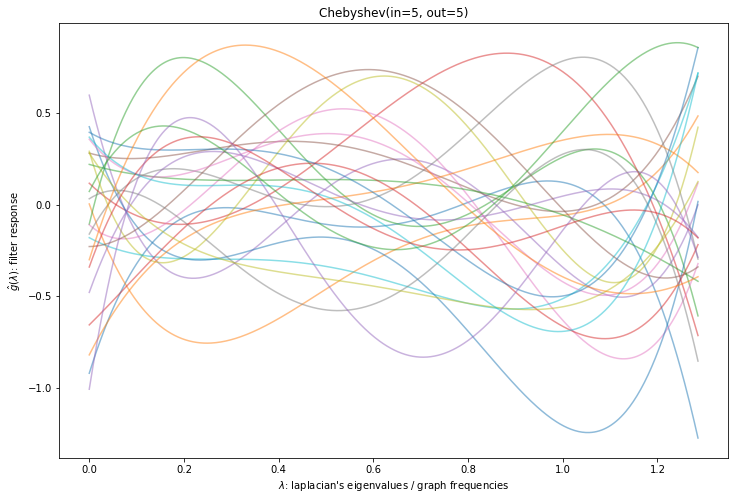

In [29]:
for i in layer:
    plt.figure(figsize=(12,8))
    model.plot_filters_spectral(i)
    plt.savefig('Plot/filters/layer_'+str(i)+'_plot_filters_spectral.jpg',bbox_inches='tight')

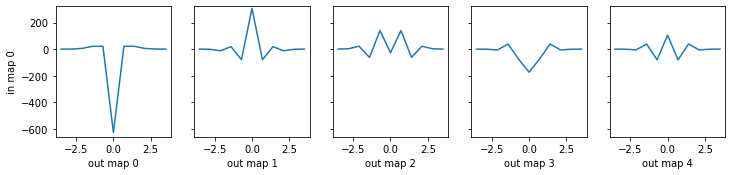

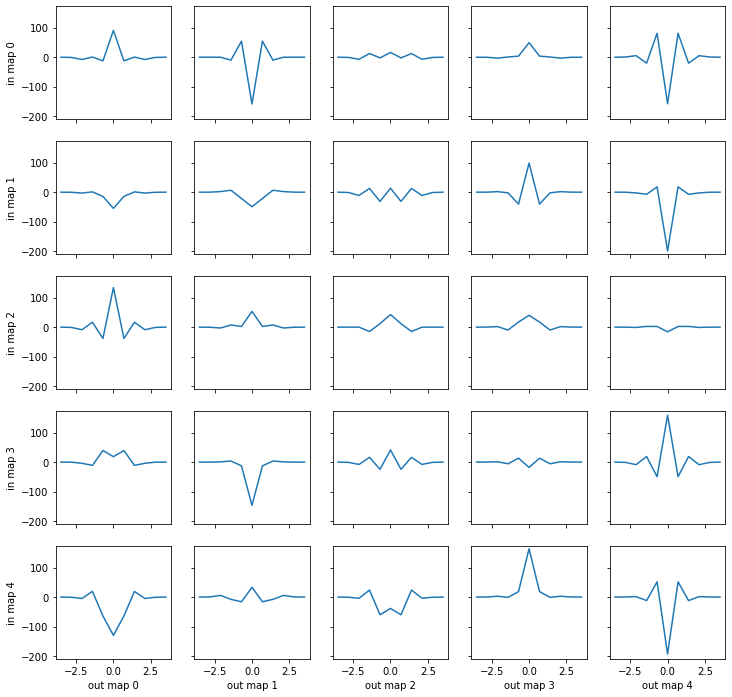

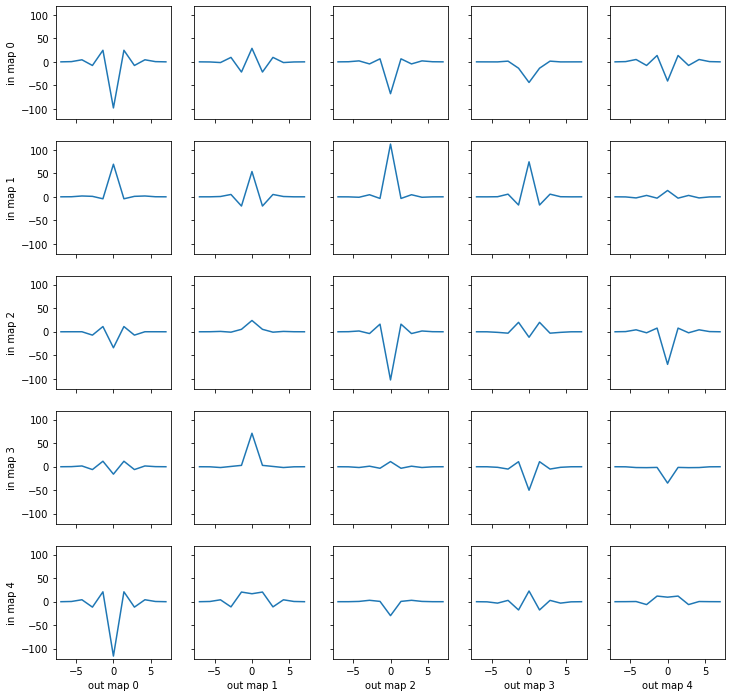

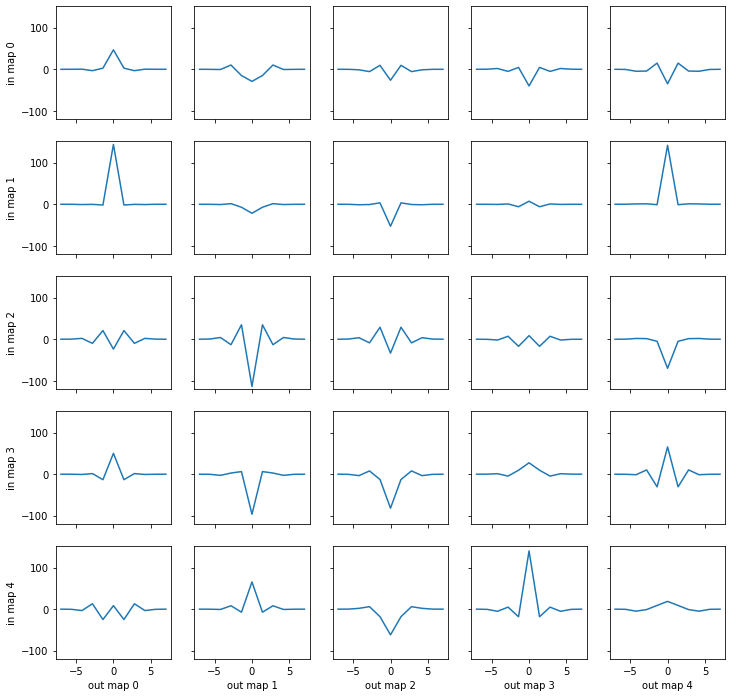

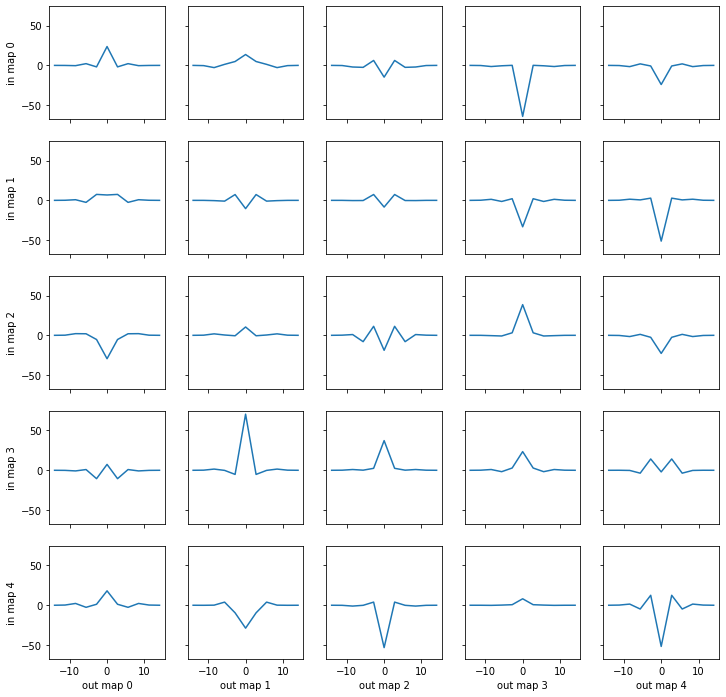

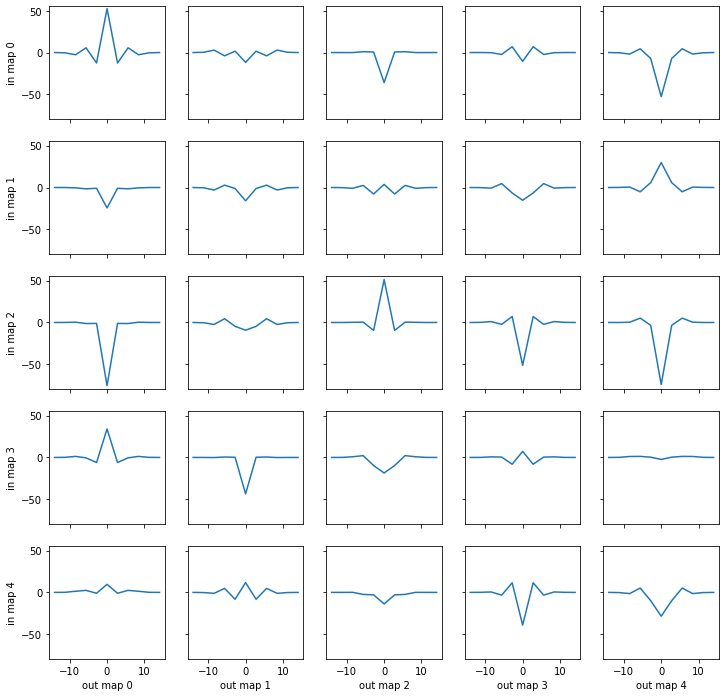

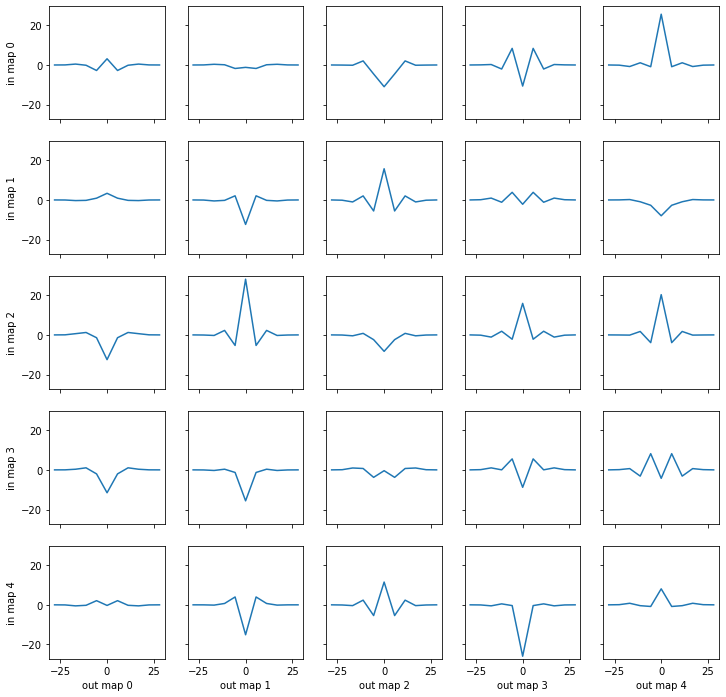

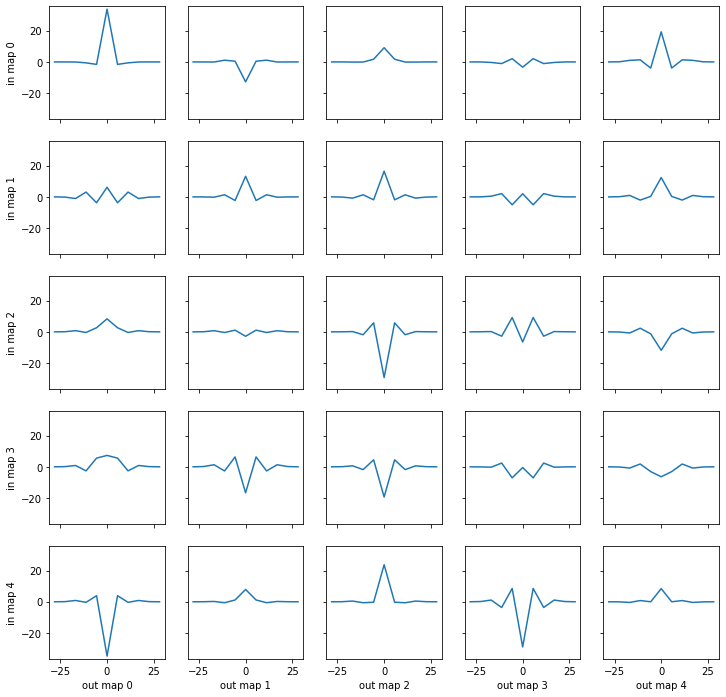

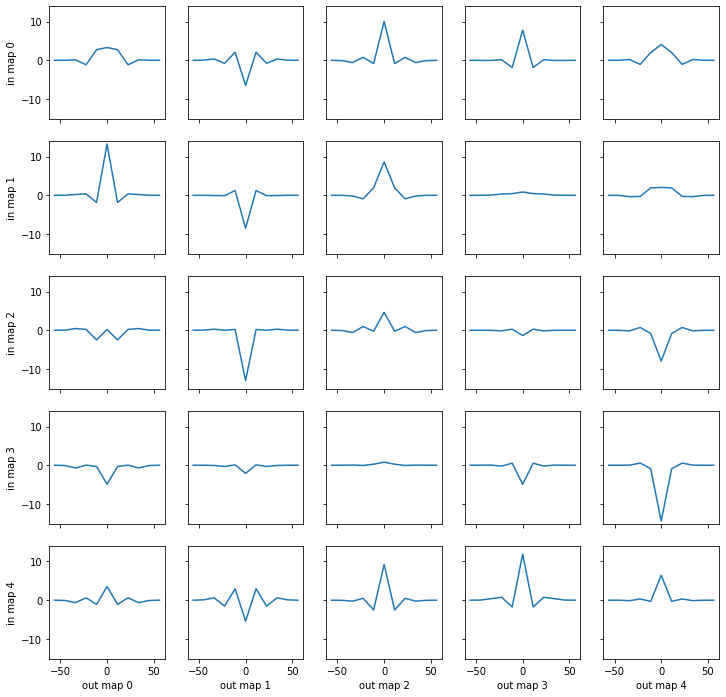

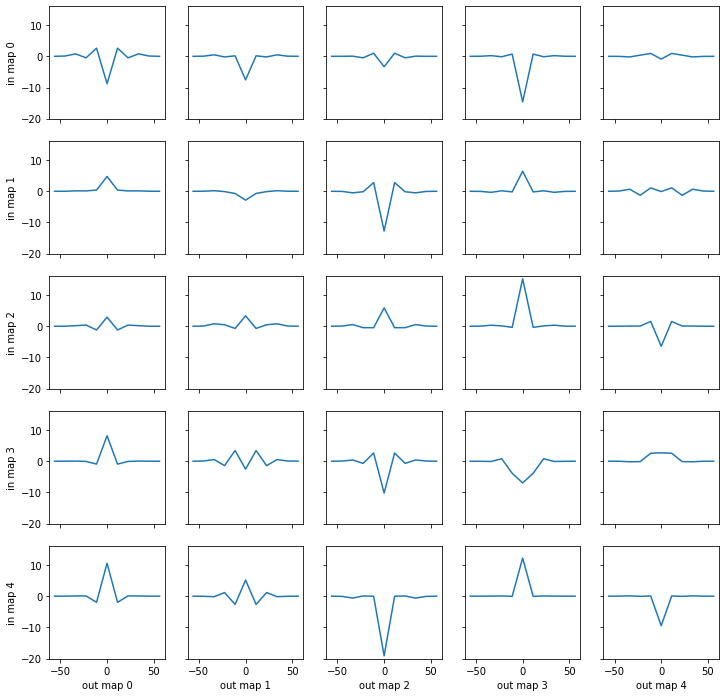

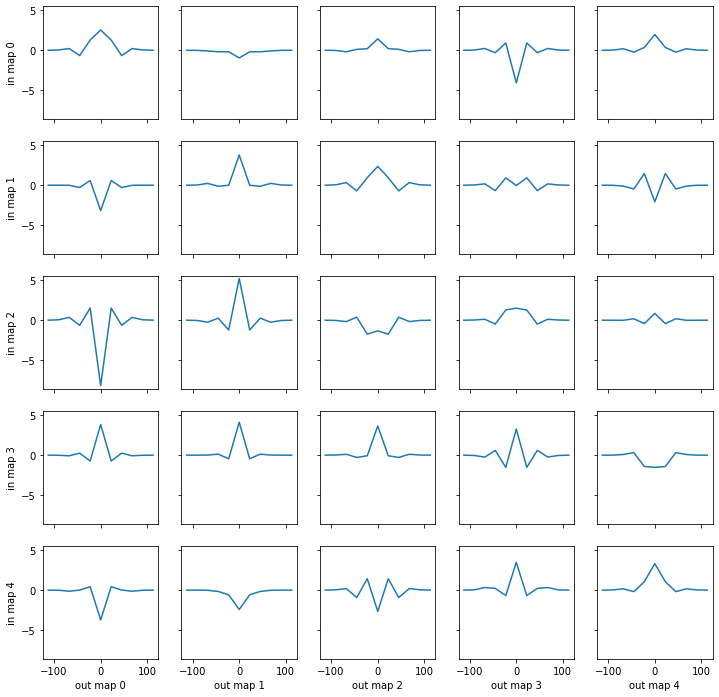

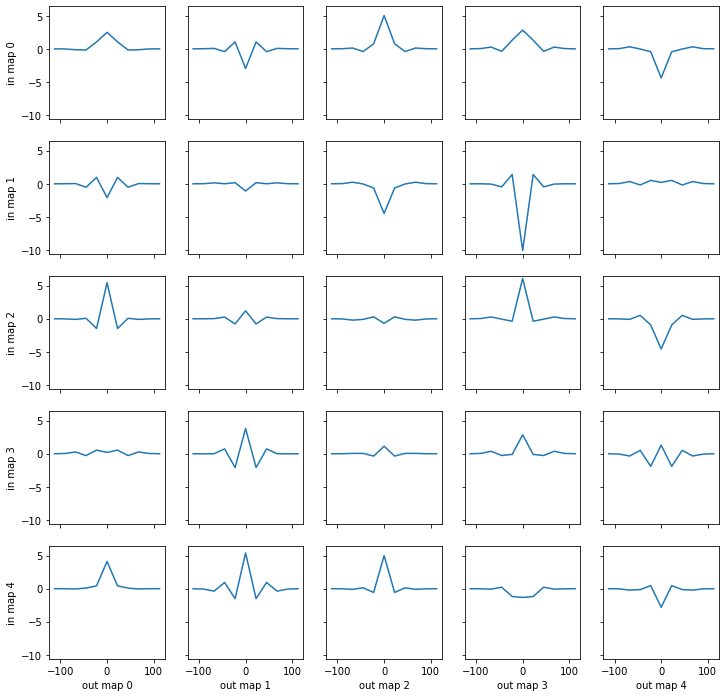

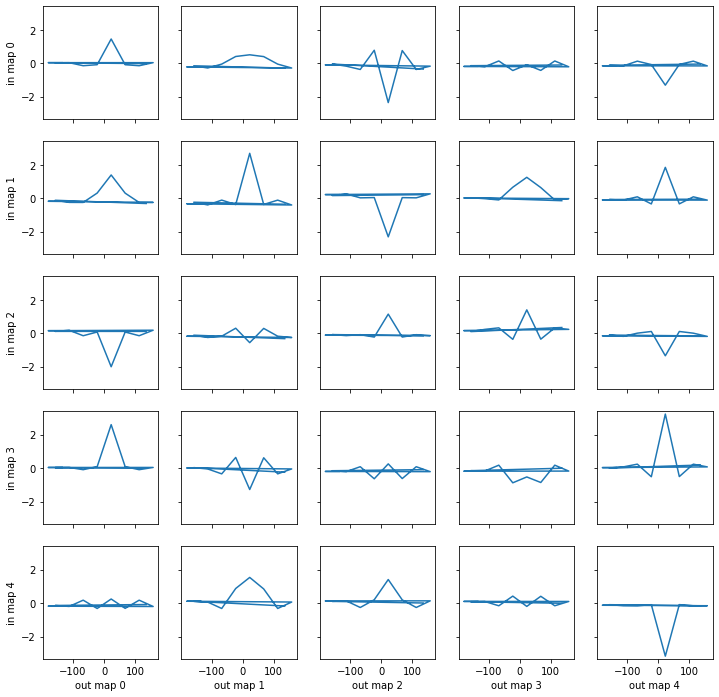

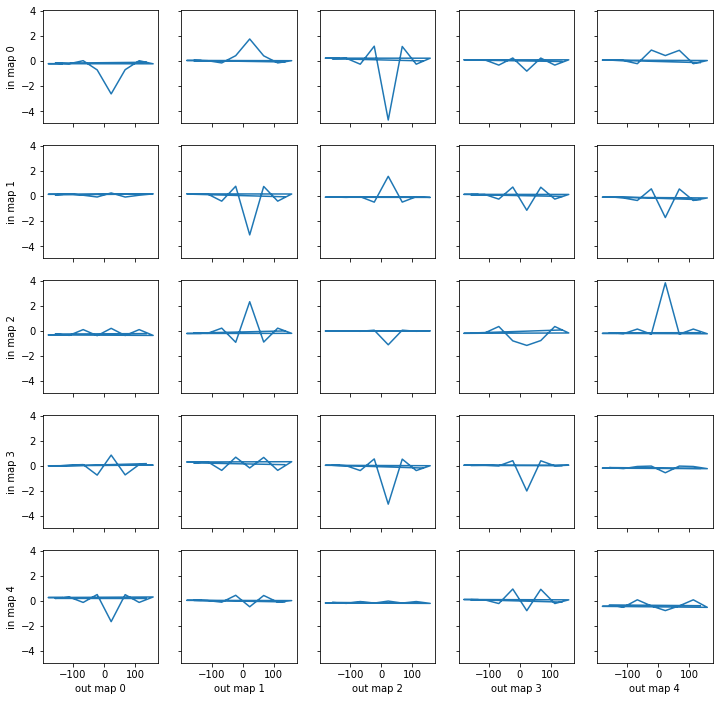

In [30]:
for i in layer:
    model.plot_filters_section(i, title='');
    plt.savefig('Plot/filters/layer_'+str(i)+'_plot_filters_section.jpg',bbox_inches='tight')

/home/r/R.Kanaki/Scratch/deepsphere-cosmo-tf2/deepsphere/plot.py:44: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cm.set_under('w')


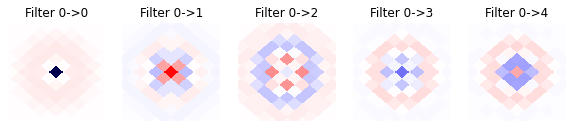

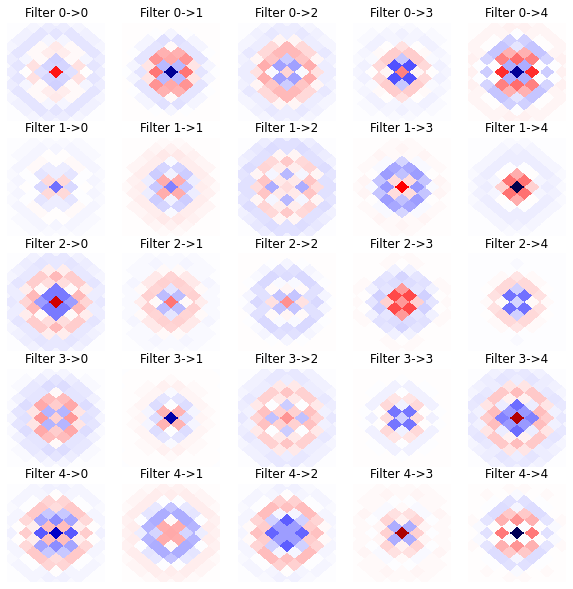

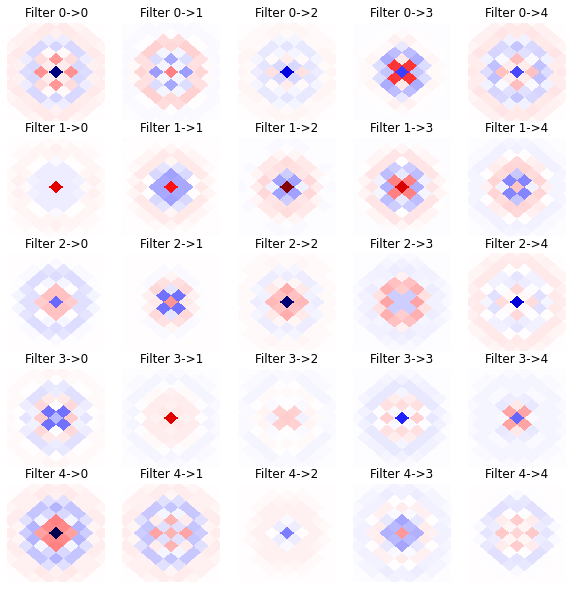

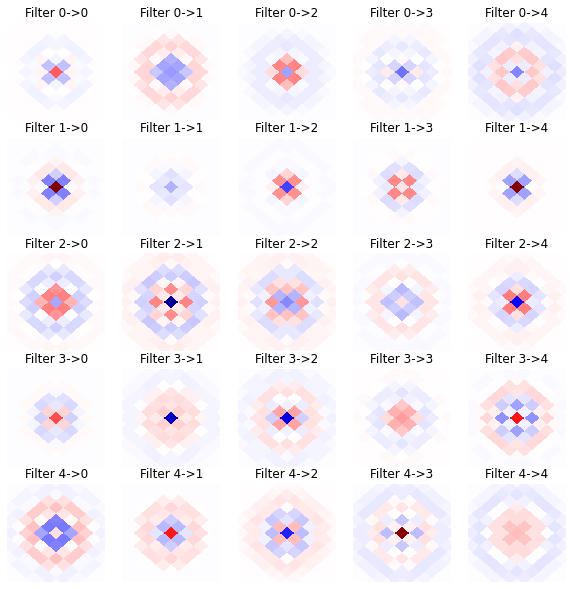

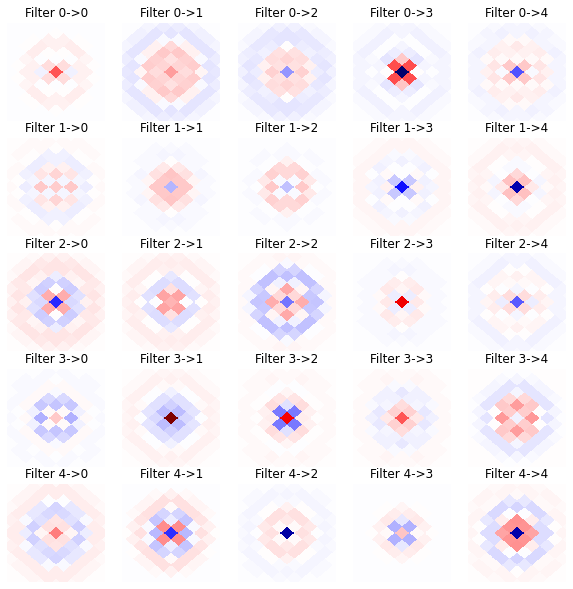

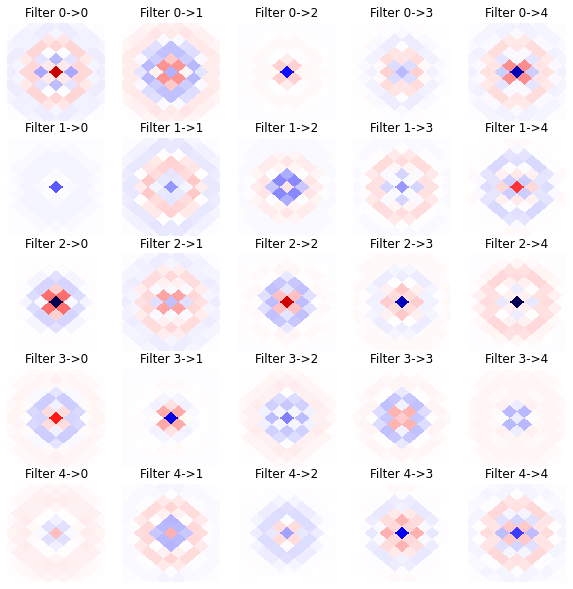

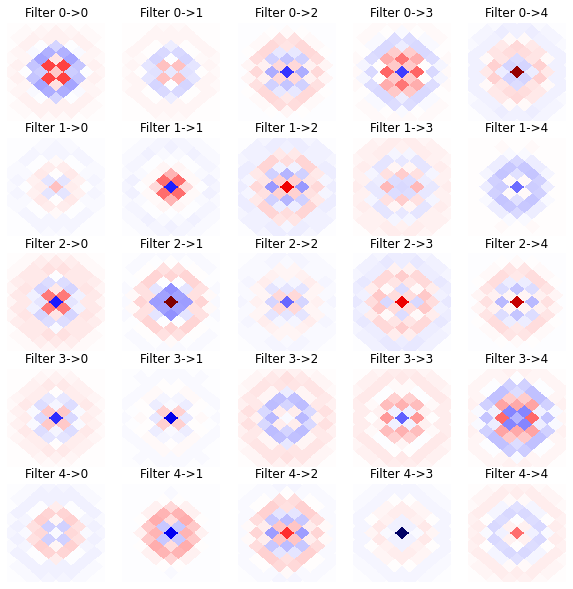

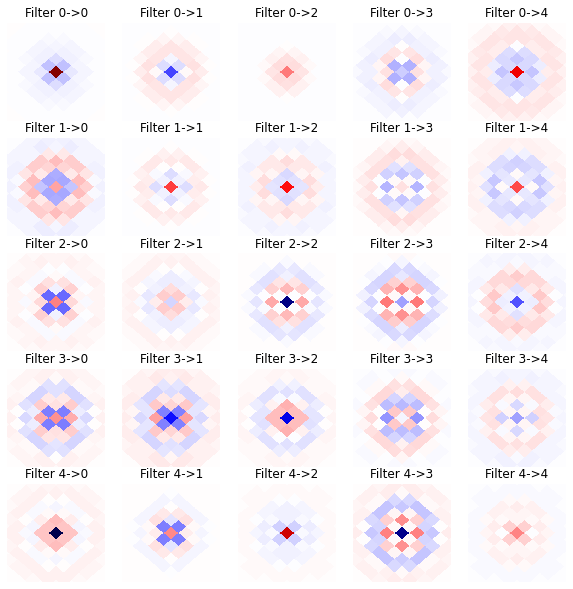

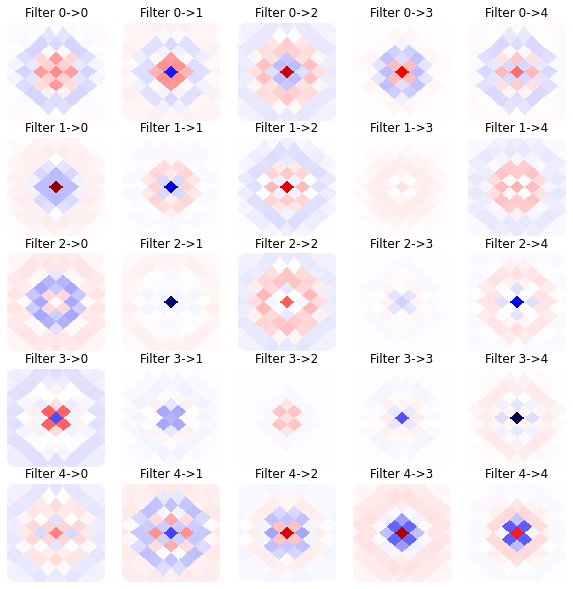

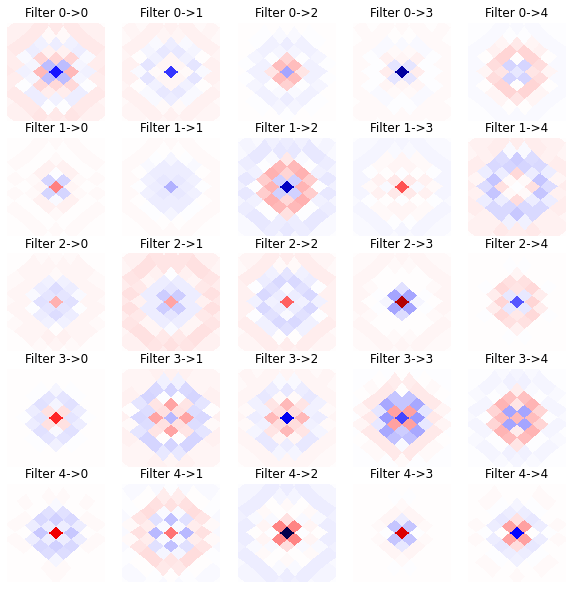

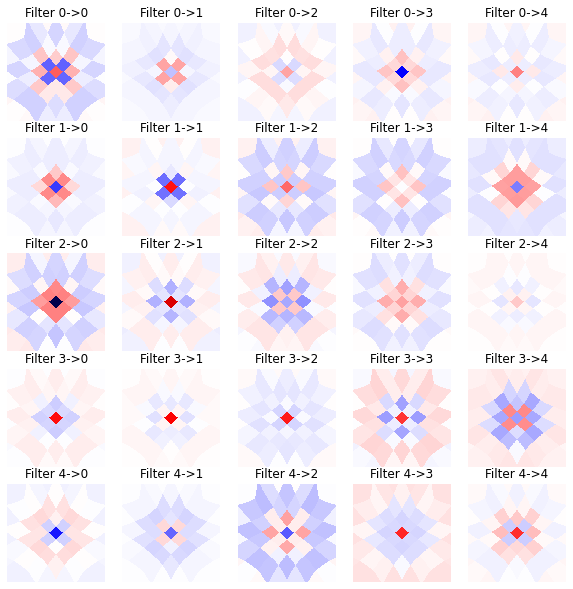

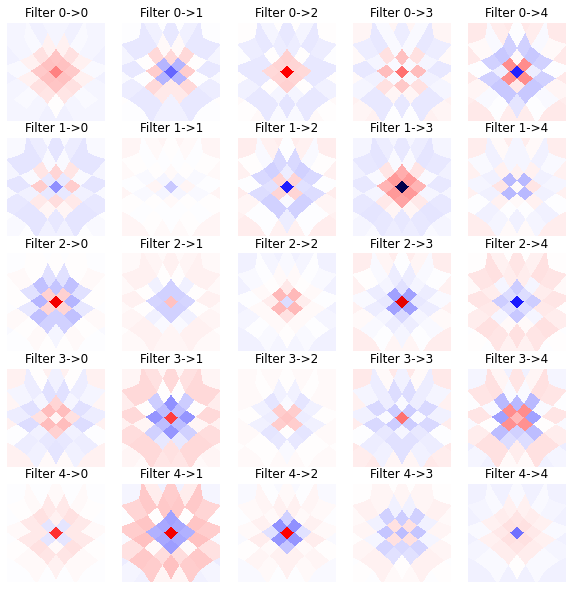

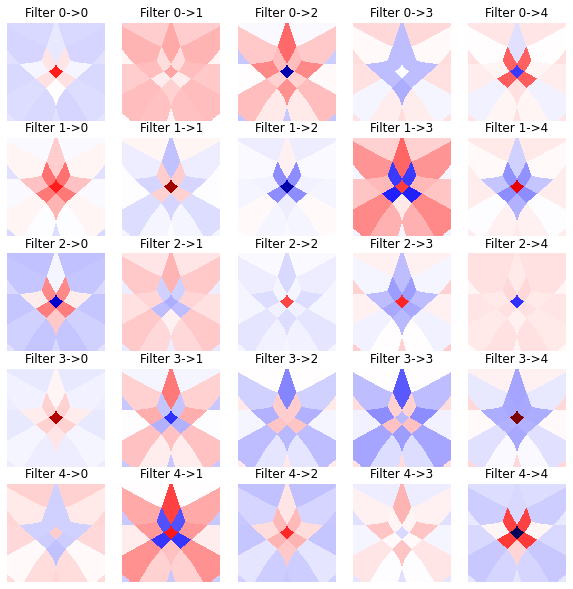

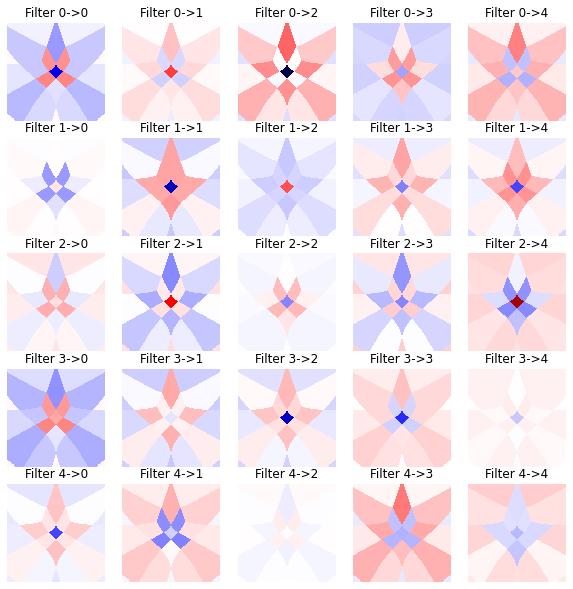

In [31]:
for i in layer:
    figs = model.plot_filters_gnomonic(i)
    plt.savefig('Plot/filters/layer_'+str(i)+'_plot_filters_gnomonic.jpg',bbox_inches='tight')